In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [2]:
path = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(path, parse_dates=['date'], index_col='date')
print(df.shape)
df.head()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8


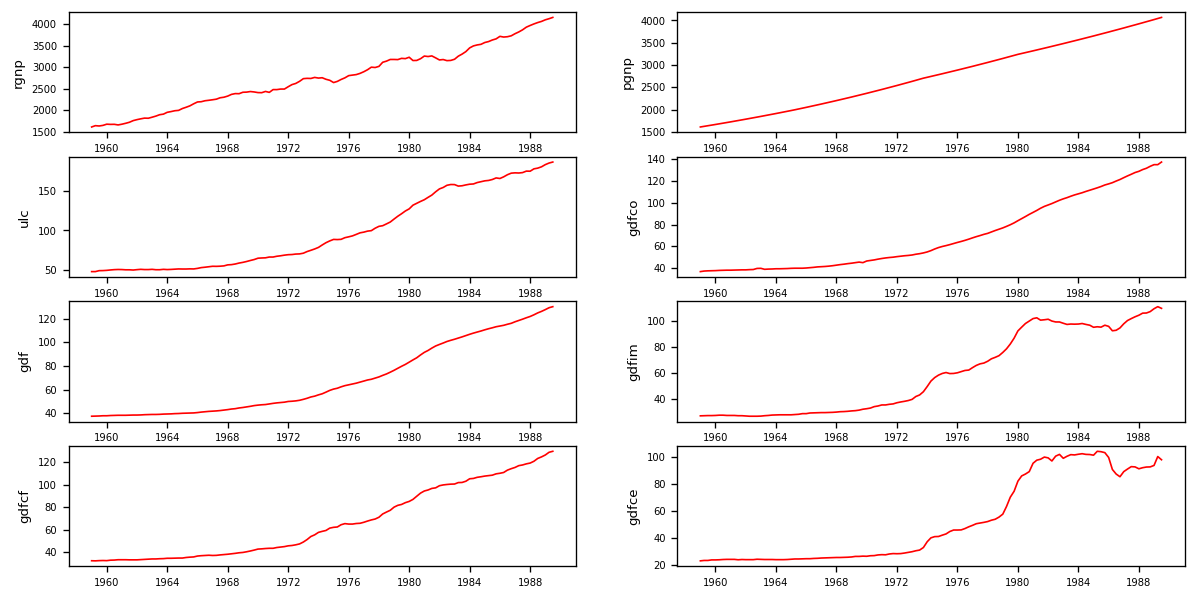

In [4]:
fig,axes=plt.subplots(nrows=4,ncols=2,figsize=(12,6),dpi=120)
for i,ax in enumerate(axes.flatten()):
  data=df[df.columns[i]]
  ax.plot(data,color='red',linewidth=1)
  ax.tick_params(axis='both',labelsize=6)
  ax.set_ylabel(df.columns[i],fontsize=8)

In [6]:
adf_fuller_1=adfuller(df['rgnp'])
adf_fuller_2=adfuller(df['ulc'])
print(adf_fuller_1[1])
print(adf_fuller_2[1])

0.9886037114305949
0.9970991728829679


In [7]:
adf_fuller_1=adfuller(df['rgnp'].diff()[1:])
adf_fuller_2=adfuller(df['ulc'].diff()[1:])
print(adf_fuller_1[1])
print(adf_fuller_2[1])

2.9633019848469254e-06
0.006235131830238172


In [11]:
print('\nrqnp causes uls ?\n')
granger1=grangercausalitytests(df[['rgnp','ulc']],maxlag=4)
print('\nuls causes rqnp ?\n')
granger2=grangercausalitytests(df[['ulc','rgnp']].diff()[1:],maxlag=4)


rqnp causes uls ?


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3729  , p=0.5426  , df_denom=119, df_num=1
ssr based chi2 test:   chi2=0.3823  , p=0.5364  , df=1
likelihood ratio test: chi2=0.3817  , p=0.5367  , df=1
parameter F test:         F=0.3729  , p=0.5426  , df_denom=119, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6201  , p=0.0117  , df_denom=116, df_num=2
ssr based chi2 test:   chi2=9.6386  , p=0.0081  , df=2
likelihood ratio test: chi2=9.2739  , p=0.0097  , df=2
parameter F test:         F=4.6201  , p=0.0117  , df_denom=116, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0976  , p=0.0084  , df_denom=113, df_num=3
ssr based chi2 test:   chi2=13.0544 , p=0.0045  , df=3
likelihood ratio test: chi2=12.3920 , p=0.0062  , df=3
parameter F test:         F=4.0976  , p=0.0084  , df_denom=113, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=

In [12]:
 df.shape

(123, 8)

In [18]:
df=df[['rgnp','ulc']]

In [19]:
train=df.iloc[:-12]
test=df.iloc[-12:]
test.shape

(12, 2)

In [20]:
model=VAR(train.diff()[1:])
x=model.select_order(maxlags=20)
x.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,6.778,6.834,878.3,6.800
1,5.988,6.154*,398.5,6.055
2,5.942,6.220,380.9,6.054
3,5.933,6.322,377.4,6.090
4,5.793*,6.293,328.5*,5.995*
5,5.873,6.484,356.3,6.120
6,5.828,6.550,341.1,6.119
7,5.894,6.727,365.0,6.230
8,5.890,6.835,364.8,6.271
9,5.942,6.998,385.8,6.368


In [21]:
var_model=VARMAX(train,order=(4,0),enforce_stationarity=True)
model=var_model.fit(disp=False)
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                           Statespace Model Results                           
Dep. Variable:        ['rgnp', 'ulc']   No. Observations:                  111
Model:                         VAR(4)   Log Likelihood               -8844.960
                          + intercept   AIC                          17731.920
Date:                Sun, 22 Sep 2024   BIC                          17788.820
Time:                        06:13:28   HQIC                         17755.003
Sample:                    01-01-1959                                         
                         - 07-01-1986                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):          107.95, 98.70   Jarque-Bera (JB):         15.44, 17.07
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.23, 0.14   Skew:                      -0.91, 0.96
Prob(H) (two-sided):            0.00,

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
n_forecast=12
forecast=model.get_prediction(start=len(train),end=len(train)+n_forecast-1)
predictions=forecast.predicted_mean
predictions.columns=['rgnp_prediction','ulc_prediction']
predictions.head()

,rgnp_prediction,ulc_prediction
1986-10-01,3481.420617,154.424111
1987-01-01,3338.082360,184.977132
1987-04-01,3651.523239,185.548332
1987-07-01,3579.651616,169.731272
1987-10-01,3564.674112,165.716315


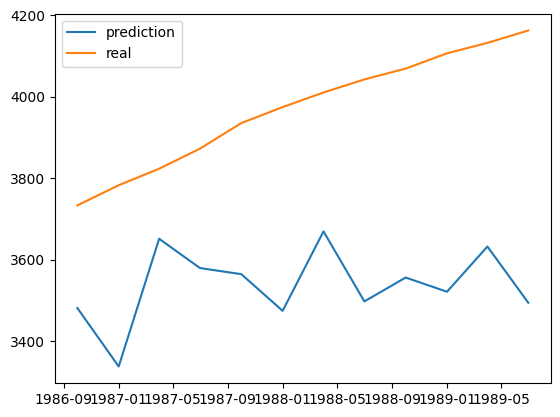

In [27]:
plt.plot(predictions['rgnp_prediction'])
plt.plot(test['rgnp'])
plt.legend(['prediction','real'])

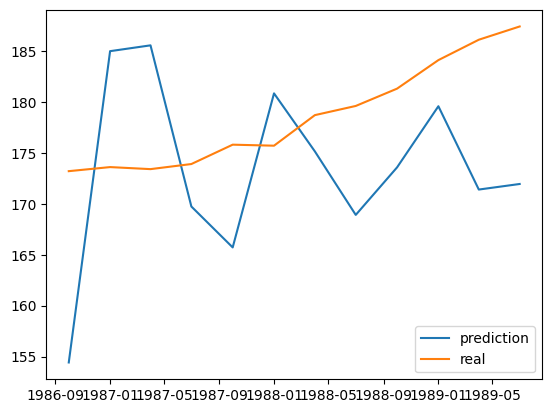

In [28]:
plt.plot(predictions['ulc_prediction'])
plt.plot(test['ulc'])
plt.legend(['prediction','real'])

In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms_rgnp=sqrt(mean_squared_error(predictions['rgnp_prediction'],test['rgnp']))
rms_ulc=sqrt(mean_squared_error(predictions['ulc_prediction'],test['ulc']))
mean_rgnp=np.mean(test['rgnp'])
mean_ulc=np.mean(test['ulc'])
print(mean_rgnp," ",rms_rgnp)
print(mean_ulc," ",rms_ulc)

3970.691666666667   454.6461161424029
178.56666666666663   10.94446679061537
